In [1]:
import pandas as pd 
import numpy as np 
import random
from math import log, sqrt 
from statistics import mode, mean
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# for the loan approval dataset we will be looking at precision as our most important performance metric.
# A higher precision means the classifier can more often identify someone who should get a loan and this means
# it will be better at not choosing people who should not get a loan which would be a loss for the bank and lead to hardship

In [3]:
# Original Dataset
loan_data = pd.read_csv("datasets/loan.csv")
loan_data.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [4]:
#returns a processed Dataframe for the Loan dataset
# *Notes* 
# left the 3+ in dependents and changed values to a string to handle this column as a catagorical attribute.
# Leaving the loan amount term as numerical, could be a categorical value if we assume these are the only terms the bank is 
# looking at
def load_data_loan():
    loan_data = pd.read_csv("datasets/loan.csv")
    
    
    # removing unneeded/biased attributes
    # we can try a few versions of this and see how leaving out or including some of these affects accuracy.
    columns_to_drop = ['Loan_ID','Gender','Married','Education','Self_Employed','Property_Area']
    loan_data = loan_data.drop(columns_to_drop,axis=1)
    
    
    return loan_data
loan_data = load_data_loan()
print(loan_data)

    Dependents  ApplicantIncome  CoapplicantIncome  LoanAmount  \
0            1             4583             1508.0         128   
1            0             3000                0.0          66   
2            0             2583             2358.0         120   
3            0             6000                0.0         141   
4            2             5417             4196.0         267   
..         ...              ...                ...         ...   
475          0             2900                0.0          71   
476         3+             4106                0.0          40   
477          1             8072              240.0         253   
478          2             7583                0.0         187   
479          0             4583                0.0         133   

     Loan_Amount_Term  Credit_History Loan_Status  
0                 360               1           N  
1                 360               1           Y  
2                 360               1           Y  

In [5]:
#information about each column
print(loan_data.dtypes)
for col in loan_data.columns:
    print(f"{col}: {loan_data[col].unique()}")

Dependents            object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount             int64
Loan_Amount_Term       int64
Credit_History         int64
Loan_Status           object
dtype: object
Dependents: ['1' '0' '2' '3+']
ApplicantIncome: [ 4583  3000  2583  6000  5417  2333  3036  4006 12841  3200  3073  1853
  1299  4950  3510  4887  7660  5955  2600  9560  2799  4226  1442  3167
  4692  3500 12500  3667  4166  3748  3600  1800  3941  5649  5821  2645
  4000  1928  3086  4230  4616 11500  2708  2132  3366  8080  3357  2500
  3029  2609  5726 10750  7100  4300  3208  1875  5266  3750  1000  3846
  1378  3988  2366  8566  5695  2958  6250  3273  4133  3620  2484  1977
  4188  1759  4288  4843  3052 11417  3800  2071  5316 14583  5568 10408
  2137  2957 10513  2014  2718  3459  4895  3316 14999  4200  5042  6950
  2698 11757  2330 14866  1538 10000  4860  6277  2577  9166  2281  3254
 39999  9538  1863  7933  3089  4167  9323  2439  2237  8000  3522  5708
  434

In [6]:
loan_data.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,480.000000,480.000000,480.000000,480.000000,480.000000
mean,5364.231250,1581.093583,144.735417,342.050000,0.854167
std,5668.251251,2617.692267,80.508164,65.212401,0.353307
min,150.000000,0.000000,9.000000,36.000000,0.000000
25%,2898.750000,0.000000,100.000000,360.000000,1.000000
50%,3859.000000,1084.500000,128.000000,360.000000,1.000000
75%,5852.500000,2253.250000,170.000000,360.000000,1.000000
max,81000.000000,33837.000000,600.000000,480.000000,1.000000


In [7]:
CATEGORICAL_COLS = ["Dependents"]

BINARY_COLS = ["Credit_History"]

CLASS_LABEL = "Loan_Status"

NUMERICAL_COLS = ["ApplicantIncome","CoapplicantIncome","LoanAmount","Loan_Amount_Term"]

CATEGORICAL_COLS_DICT = {"Dependents":['1','0','2','3+']}

# {"WifeEducation":[1,2,3,4], 
#                          "HusbandEducation":[1,2,3,4], 
#                          "WifeReligion":[0,1], 
#                          "WifeWorking":[0,1],
#                          "HusbandOccupation":[1,2,3,4], 
#                          "LivingStandardIndex":[1,2,3,4] ,
#                          "MediaExposure":[0,1]}

MAX_TREE_DEPTH = 4


In [8]:
def compute_information_gain(data, attributes, label_col_name, debug=False):
    best_attribute = None 
    best_info_gain = None 
    best_attrs_value_len = None
    best_attributes_attribute_value = []
    # base information gain 
    total_rows = len(data)
    unique_labels = data[label_col_name].unique()
    
    #calculate the base information gain for calculation later on 

    base_info_gain = 0
    overall_label_probs = [] 
    for label in unique_labels:
        overall_label_prob = len(data[data[label_col_name]==label])/ total_rows 
        base_info_gain = base_info_gain - overall_label_prob*log(overall_label_prob,2)
        overall_label_probs.append(overall_label_prob)
    
    #iterate through given attributes in this case 
    for attribute in attributes:
        attribute_values = data[attribute].unique() # need to find the unique values for the attribute 
        attribute_entropies = []
        attribute_lengths = [] 
        # We need to observe where this attribute is 0, 1, and 2 to calculate the entropy 
        # and for each do the calculations where the target class is 0 and 1 
        
        if attribute in CATEGORICAL_COLS:        
            for attribute_value in attribute_values: 
                total_attribute_type = len(data[data[attribute]==attribute_value])
                if total_attribute_type == 0:
                    attribute_type_entropy = 0 
                else:
                    attribute_type_entropy = 0 

                    for label in unique_labels:
                        attr_label_prob = len(data[(data[attribute]==attribute_value)&(data[label_col_name]==label)])/total_attribute_type
                        if attr_label_prob != 0:
                            attribute_type_entropy = attribute_type_entropy - attr_label_prob*log(attr_label_prob,2)
                attribute_entropies.append(attribute_type_entropy)
                attribute_lengths.append(total_attribute_type)
        else: # this means that it is numeric 

            # either the attribute value is greater than or less than the average 
            attr_avg = mean(data[attribute])
            attribute_values = ["greater_than" ,"less_than"]
            for attribute_value in attribute_values:
                if attribute_value == "greater_than":
                    total_attribute_type = len(data[data[attribute]>attr_avg])
                else:
                    total_attribute_type = len(data[data[attribute]<=attr_avg])
                if total_attribute_type == 0:
                    attribute_type_entropy = 0 
                else:
                    attribute_type_entropy = 0 

                    for label in unique_labels:
                        if attribute_value == "greater_than":
                            # error here 
                            attr_label_prob = len(data[(data[attribute]>attr_avg)&(data[label_col_name]==label)])/total_attribute_type
                        else: 
                            attr_label_prob = len(data[(data[attribute]<=attr_avg)&(data[label_col_name]==label)])/total_attribute_type
                        
                        if attr_label_prob != 0:
                            attribute_type_entropy = attribute_type_entropy - attr_label_prob*log(attr_label_prob,2)
                attribute_entropies.append(attribute_type_entropy)
                attribute_lengths.append(total_attribute_type)

            
       
        #use all the calculations above to produce the total entropy and the information gain 
        total_entropy = 0
        for i in range(len(attribute_values)):
            total_entropy = total_entropy + (attribute_lengths[i]/ total_rows * attribute_entropies[i])
        gain = base_info_gain - total_entropy

        # storing the attribute if it is the attribute with the best information gain 
        if not best_info_gain:
            best_info_gain = gain 
            best_attribute = attribute
            best_attrs_value_len = len(attribute_values) if len(attribute_values) < 10 else 2 
            best_attributes_attribute_value = attribute_values
        else: 
            if best_info_gain < gain:
                best_info_gain = gain 
                best_attribute = attribute
                best_attrs_value_len = len(attribute_values) if len(attribute_values) < 10 else 2 
                best_attributes_attribute_value = attribute_values
        
    return best_info_gain, best_attribute, list(best_attributes_attribute_value)

In [9]:
class root():
    def __init__(self, label_col_name, data) -> None:
        self.train_data = data 
        self.child_nodes = []
        self.best_attribute = None
        self.label_col_name = label_col_name

        self.train_decision_tree()

    def train_decision_tree(self):
        # finding the inital attribute to split on 
        attributes = [col for col in self.train_data.columns if col != self.label_col_name]
        unique_class_labels = self.train_data[self.label_col_name].unique()
        majority_class = None
        max_class_frequency = 0 
        for label in unique_class_labels: 
            class_frequency = len(self.train_data[self.train_data[self.label_col_name] == label])
            if majority_class == None:
                majority_class = label 
                max_class_frequency = class_frequency
            else: 
                if max_class_frequency < class_frequency:
                    max_class_frequency = class_frequency
                    majority_class = label 

        # compute the best attribute using information gain 
        # choose a random set of attributes 
        num_attrs = int(sqrt(len(attributes)))
        attrs_to_use = random.choices(attributes, k=num_attrs)
        _, best_attribute, attribute_values = compute_information_gain(self.train_data, attrs_to_use, self.label_col_name)

        # split the dataset based on the attribute values (0,1,2) and create three child nodes 
        depth = 1 
        initial_child_nodes = [] 

        if best_attribute in CATEGORICAL_COLS:
            attribute_values = CATEGORICAL_COLS_DICT[best_attribute]
            for r in attribute_values: 
                child_node = Node(self.label_col_name, self.train_data[self.train_data[best_attribute]==r], best_attribute, r, attributes, majority_class, depth)
                initial_child_nodes.append(child_node)
        else:
            attr_avg = mean(self.train_data[best_attribute])
            child_node_one = Node(self.label_col_name, self.train_data[self.train_data[best_attribute]>attr_avg], best_attribute, attr_avg, attributes, majority_class, depth, greater_than=True)
            child_node_two = Node(self.label_col_name, self.train_data[self.train_data[best_attribute]<=attr_avg], best_attribute, attr_avg, attributes, majority_class, depth, greater_than=False)
            initial_child_nodes = [child_node_one,child_node_two]
        
        self.child_nodes = initial_child_nodes
        self.best_attribute = best_attribute

    def find_class(self, row, node, depth):
        # iterate/ search decision tree to fin the desired target class 
        depth = depth+1
        # termination case
        if node.is_leaf_node:
            return node.target_class
        else: 
            #child_attribute_value to select next attribute
            attr = node.child_nodes[0].my_attribute
            
            #selecting the next branch 
            row_attr_val = row[attr]
            next_node = None
            if attr in CATEGORICAL_COLS: 
                for child in node.child_nodes:
                    if row_attr_val == child.my_attribute_value:
                        next_node = child
            else: 
                child_attr_val = node.child_nodes[0].my_attribute_value
                if row_attr_val> child_attr_val:
                    for child in node.child_nodes:
                        if child.greater_than:
                            next_node = child
                else: 
                    for child in node.child_nodes:
                        if not child.greater_than:
                            next_node = child
            if next_node == None:
                x ="Sad"
            return self.find_class(row, next_node, depth)




    def run_experiment_decision_tree(self, data):
        count = 0 
        predictions = [] 
        for index, row in data.iterrows():
            next_node = None 
            row_attr_val = row[self.best_attribute]

            if self.best_attribute in CATEGORICAL_COLS:
                for child in self.child_nodes:
                    if row_attr_val == child.my_attribute_value:
                        next_node = child
            else:
                child_attr_val = self.child_nodes[0].my_attribute_value
                if row_attr_val> child_attr_val:
                    for child in self.child_nodes:
                        if child.greater_than:
                            next_node = child
                else:
                    for child in self.child_nodes:
                        if not child.greater_than:
                            next_node = child
            # error here 
            if next_node == None:
                x= "Sad"
            final_class = self.find_class(row, next_node, 1)
            if final_class == row[self.label_col_name]:
                count = count + 1
            predictions.append(final_class)
        return count/len(data), predictions


In [10]:
class Node():
    def __init__(self, label_col_name,  data, my_attribute, attribute_value, attributes, my_parent_majority_class, depth,  greater_than = None):
        # storing the data, attribute and attribute value on which this node was created on and the 
        # remaining attributes 
        self.my_data = data 
        self.my_attribute = my_attribute
        self.my_attribute_value = attribute_value
        self.my_attributes = attributes 
        self.depth = depth + 1 
        self.label_col_name = label_col_name
        self.greater_than = greater_than
        # only for the instance the data is empty, should become the target class 
        self.my_parent_majority_class = my_parent_majority_class 
        
        #these will be set thoughout the remaining logic 
        self.is_leaf_node = False 
        self.child_nodes = None 
        self.target_class = None
        
        
        total_data_instance = len(data)
        # TODO fix this from hardcoding
        # target_class_zero_len = len(data[data["class"]==0])
        # target_class_one_len = len(data[data["class"]==1])
        
        unique_class_labels = data[self.label_col_name].unique()
        majority_class = None
        max_class_frequency = 0 
        for label in unique_class_labels: 
            class_frequency = len(self.my_data[self.my_data[self.label_col_name] == label])
            if majority_class == None:
                majority_class = label 
                max_class_frequency = class_frequency
            else: 
                if max_class_frequency < class_frequency:
                    max_class_frequency = class_frequency
                    majority_class = label 

        # if there is no data then set the final target class as the parent majority class 
        # and then set the node as the leaf node 
        if total_data_instance == 0: 
            self.target_class = self.my_parent_majority_class
            self.is_leaf_node = True 
            
        else: 
            # if all the data belongs to target class 0 then set that as the final target class
            # and then the node as a leaf node 
            if total_data_instance == max_class_frequency:
                self.target_class = majority_class
                self.is_leaf_node = True 
            # there are no remaining attributes to split on so just set the target class to majority class in
            # the dataset
            elif len(attributes) ==0:
                # majority_class = 0 if target_class_zero_len> target_class_one_len else 1 
                self.target_class = majority_class
                self.is_leaf_node = True 
            elif self.depth == MAX_TREE_DEPTH:
                # majority_class = 0 if target_class_zero_len> target_class_one_len else 1 
                self.target_class = majority_class
                self.is_leaf_node = True 
            else:
                # find the majority target class (this will come in handy if there is an empty dataset for child node)
                #majority_class = 0 if target_class_zero_len> target_class_one_len else 1 

                # compute the best attribute using information gain 
                # choose a random set of attributes 
                num_attrs = int(sqrt(len(attributes)))
                attrs_to_use = random.choices(attributes, k=num_attrs)
                _, best_attribute, best_attributes_attribute_value = compute_information_gain(self.my_data, attrs_to_use, self.label_col_name)
                new_attrs = attributes
                # split the dataset base of the attribute values (0,1,2) and create three child nodes 
                child_nodes = [] 
                if best_attribute in CATEGORICAL_COLS:
                    attribute_values = CATEGORICAL_COLS_DICT[best_attribute]
                    # TODO: This is chard coded and may cause problems 
                    for r in attribute_values:
                        child_node = Node(self.label_col_name, data[data[best_attribute]==r], best_attribute, r, new_attrs, majority_class, self.depth)
                        child_nodes.append(child_node)
                else:
                    attr_avg = mean(data[best_attribute])
                    child_node_one = Node(self.label_col_name, data[data[best_attribute]>attr_avg], best_attribute, attr_avg, new_attrs, majority_class, self.depth, greater_than=True)
                    child_node_two = Node(self.label_col_name, data[data[best_attribute]<=attr_avg], best_attribute, attr_avg, new_attrs, majority_class, self.depth, greater_than=False)
                    child_nodes = [child_node_one,child_node_two]
                self.child_nodes = child_nodes
                #self.child_nodes = [child_node_zero, child_node_one, child_node_two]

In [11]:
class forest():
    def __init__(self, label_col_name, n_trees, chunks, valid_chunks) -> None:
        self.n_trees = n_trees
        self.chunks = chunks 
        self.trees = [] 
        self.valid_chunks = valid_chunks
        self.label_col_name = label_col_name
        # here we need to implement a bootstrapping algorithm where each tree needs to recieve a synthetic dataset 
        for i in range(self.n_trees):
            train_data = self.create_synthetic_dataset()
            # each tree needs to get a synthetic dataset 
            tree = root(self.label_col_name, train_data)
            self.trees.append(tree)

    def test(self, test_data):
        tree_predictions = []
        for tr in self.trees: 
            _, test_preds = tr.run_experiment_decision_tree(test_data)
            tree_predictions.append(test_preds)
        # find the majority vote for each prediction 
        majority_preds = [mode([preds[i] for preds in tree_predictions]) for i in range(len(test_data))]
        return majority_preds
    
    def create_synthetic_dataset(self):
        # pick some random chunks 
        random_pick = [random.choice(self.valid_chunks) for d in range(len(self.valid_chunks))]
        all_data = [self.chunks[val] for val in random_pick]
        all_data_concated = pd.concat(all_data)
        return all_data_concated


In [12]:
def plot_decision_tree_distribution(data, name=""):
    standard_deviation = np.std(data)
    standard_deviation_stringified = "{:1.4f}".format(standard_deviation)
    _ = plt.hist(data, bins= 30)
    title = name + " std =" + standard_deviation_stringified
    plt.title(title)
    plt.show()

In [13]:
def plot_forest_data(n_trees, data, dataset_name, metric):
    plt.scatter(n_trees, data)
    title = dataset_name + metric 
    plt.title(title)
    plt.xlabel("N Trees")
    plt.ylabel(metric)
    plt.show()

In [14]:
def create_stratified_training_chunks_loan(loan_data):
    label_col = CLASS_LABEL
    
    class_zero_data =loan_data[loan_data[label_col] == 'N' ]
    class_one_data = loan_data[loan_data[label_col] == 'Y' ]
#     class_two_data = loan_data[loan_data[label_col] == 3 ]


    chunks = {} 
    total_k = 10
    #could shuffle data first
    class_zero_chunk_len = int(round(len(class_zero_data)/ total_k))
    class_one_chunk_len = int(round(len(class_one_data)/ total_k))
#     class_two_chunk_len = int(round(len(class_two_data)/ total_k))

    for k in range(total_k):
        if k < total_k -1:
            class_zero_chunk = class_zero_data[k*class_zero_chunk_len:(k+1)*class_zero_chunk_len]
            class_one_chunk = class_one_data[k*class_one_chunk_len:(k+1)*class_one_chunk_len]
#             class_two_chunk = class_two_data[k*class_two_chunk_len:(k+1)*class_two_chunk_len]
            chunks[k] = pd.concat([class_zero_chunk,class_one_chunk])
            
            
        else:
            class_zero_chunk = class_zero_data[k*class_zero_chunk_len:]
            class_one_chunk = class_one_data[k*class_one_chunk_len:]
#             class_two_chunk = class_one_data[k*class_two_chunk_len:]
            chunks[k] = pd.concat([class_zero_chunk,class_one_chunk])
    return chunks, label_col, loan_data

In [15]:
def get_tp_fp_tn_fn(test_set_actuals, preds, positive_class):
    # may need to alter this to just be one class, 'Y' in this case...
    TP = 0
    FN = 0
    FP = 0
    TN = 0 
    for i in range(len(test_set_actuals)):
        if test_set_actuals[i] == positive_class:
            if preds[i] == positive_class:
                TP = TP + 1 
            else: 
                FN = FN + 1 
        else:
            if preds[i] == positive_class:
                FP = FP + 1 
            else: 
                TN = TN + 1 
    recall = TP/(TP + FN) if (TP + FN) != 0 else 0 
    precision = TP/(TP + FP) if (TP + FP) != 0 else 0 
    f1_score = 2 * precision*recall/(precision + recall) if (precision + recall) != 0 else 0
    accuracy = (TP + TN)/ (TP+FP+TN+FN)
    return recall, precision, f1_score

k:  0
k:  1
k:  2
k:  3
k:  4
k:  5
k:  6
k:  7
k:  8
k:  9


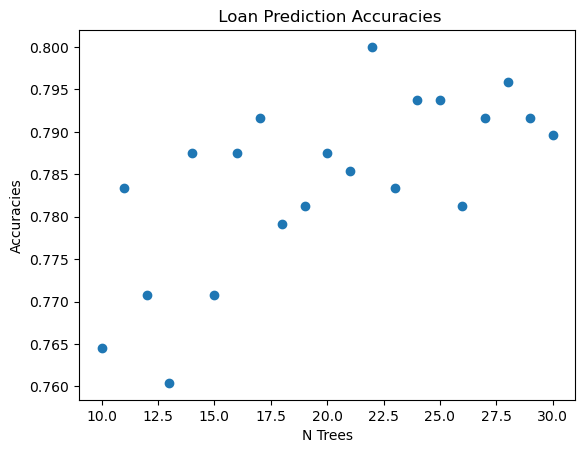

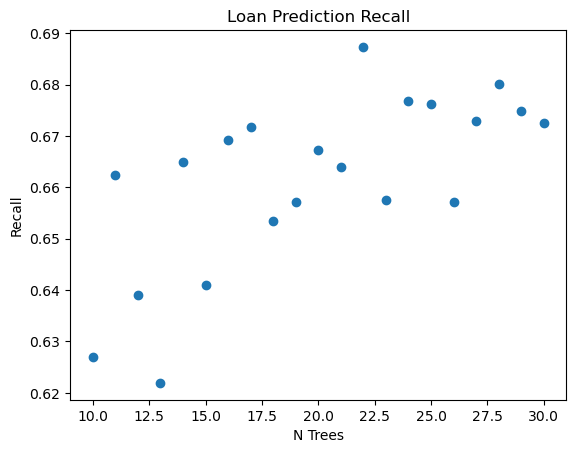

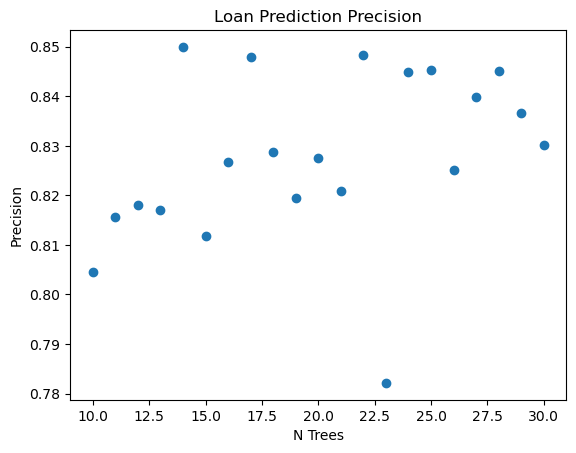

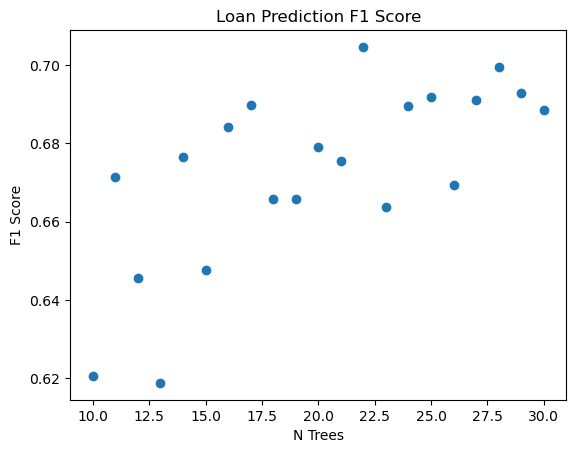

Loan Prediction Accuracies
{10: 0.7645833333333333, 11: 0.7833333333333333, 12: 0.7708333333333334, 13: 0.7604166666666667, 14: 0.7875, 15: 0.7708333333333334, 16: 0.7875, 17: 0.7916666666666667, 18: 0.7791666666666667, 19: 0.78125, 20: 0.7875, 21: 0.7854166666666667, 22: 0.8, 23: 0.7833333333333333, 24: 0.79375, 25: 0.79375, 26: 0.78125, 27: 0.7916666666666666, 28: 0.7958333333333334, 29: 0.7916666666666667, 30: 0.7895833333333333}
Loan Prediction Recall
{10: 0.627016317016317, 11: 0.6624708624708625, 12: 0.6391142191142191, 13: 0.6219347319347319, 14: 0.664988344988345, 15: 0.6409324009324009, 16: 0.6691375291375291, 17: 0.6716550116550116, 18: 0.6534731934731934, 19: 0.6570862470862471, 20: 0.6673193473193473, 21: 0.663986013986014, 22: 0.6873193473193473, 23: 0.6575757575757576, 24: 0.6768065268065268, 25: 0.6762937062937063, 26: 0.6570862470862471, 27: 0.6729603729603729, 28: 0.6801398601398602, 29: 0.6747785547785548, 30: 0.6724708624708624}
Loan Prediction Precision
{10: 0.80461

In [27]:
def run_loan():
    total_k = 10 
    chunks, label,  _ = create_stratified_training_chunks_loan(loan_data)
#     n_trees_to_run = [1, 10, 20, 30, 40, 50,70,100,150,200,400]
    n_trees_to_run = list(range(10, 31))
    unique_label_classes  = ['N', 'Y']

    n_tree_dict_accuracy = {n:[] for n in n_trees_to_run}
    n_tree_dict_recall = {n:[] for n in n_trees_to_run}
    n_tree_dict_precision= {n:[] for n in n_trees_to_run}
    n_tree_dict_f1_score = {n:[] for n in n_trees_to_run}    
    for k in range(total_k):
        print("k: ",k)
        to_choose_from = [c for c in range(total_k) if c != k ]
        test_set = chunks[k]
        # send to forest 

        for n_tree in n_trees_to_run:
            rf = forest(label, n_tree, chunks, to_choose_from)
            preds = rf.test(test_set)
            test_set_actuals = list(test_set[label])
            count = 0 
            for i in range(len(test_set)):
                if test_set_actuals[i] == preds[i]:
                    count = count + 1 
            testing_accuracy = count/len(test_set)
            temp_recalls = []
            temp_precisions = []
            temp_f1_scores = []

            for unique_label in unique_label_classes:
                recall, precision, f1_score = get_tp_fp_tn_fn(test_set_actuals, preds, unique_label)
                temp_recalls.append(recall)
                temp_precisions.append(precision)
                temp_f1_scores.append(f1_score)
            
            n_tree_dict_accuracy[n_tree].append(testing_accuracy)          
            n_tree_dict_recall[n_tree].append(mean(temp_recalls))
            n_tree_dict_precision[n_tree].append(mean(temp_precisions))
            n_tree_dict_f1_score[n_tree].append(mean(temp_f1_scores))      

    n_tree_dict_accuracy_average = {n:None for n in n_trees_to_run}
    n_tree_dict_recall_average = {n:None for n in n_trees_to_run}
    n_tree_dict_precision_average = {n:None for n in n_trees_to_run}
    n_tree_dict_f1_score_average = {n:None for n in n_trees_to_run}
    for value in n_trees_to_run:
        n_tree_dict_accuracy_average[value] = mean(n_tree_dict_accuracy[value])
        n_tree_dict_recall_average[value] = mean(n_tree_dict_recall[value])
        n_tree_dict_precision_average[value] = mean(n_tree_dict_precision[value])
        n_tree_dict_f1_score_average[value] = mean(n_tree_dict_f1_score[value])

    plot_forest_data(n_tree_dict_accuracy_average.keys(), n_tree_dict_accuracy_average.values(), " Loan Prediction ", "Accuracies")
    plot_forest_data(n_tree_dict_recall_average.keys(), n_tree_dict_recall_average.values(), "Loan Prediction ",  "Recall")
    plot_forest_data(n_tree_dict_precision_average.keys(), n_tree_dict_precision_average.values(), "Loan Prediction ", "Precision")
    plot_forest_data(n_tree_dict_f1_score_average.keys(), n_tree_dict_f1_score_average.values(), "Loan Prediction ", "F1 Score")
    
    print("Loan Prediction Accuracies")
    print (n_tree_dict_accuracy_average)
    print("Loan Prediction Recall")
    print (n_tree_dict_recall_average)
    print("Loan Prediction Precision")
    print (n_tree_dict_precision_average)
    print("Loan Prediction F1 Score")
    print (n_tree_dict_f1_score_average)


run_loan()

In [24]:
#now to explore if we had not removed any of the attributes removed for ethical reasons

loan_data = pd.read_csv("datasets/loan.csv")
    
# removing unneeded/biased attributes
# we can try a few versions of this and see how leaving out or including some of these affects accuracy.
columns_to_drop = ['Loan_ID']
loan_data = loan_data.drop(columns_to_drop,axis=1)
print(loan_data.columns)
print(loan_data.dtypes)

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount             int64
Loan_Amount_Term       int64
Credit_History         int64
Property_Area         object
Loan_Status           object
dtype: object


In [25]:
CATEGORICAL_COLS = ["Gender","Married","Dependents","Education","Self_Employed","Property_Area"]

# BINARY_COLS = ["Credit_History"] What does this do?

CLASS_LABEL = "Loan_Status"

NUMERICAL_COLS = ["ApplicantIncome","CoapplicantIncome","LoanAmount","Loan_Amount_Term"]

CATEGORICAL_COLS_DICT = {}

for col in CATEGORICAL_COLS:
    CATEGORICAL_COLS_DICT[col] = loan_data[col].unique()
# print(CATEGORICAL_COLS_DICT)
MAX_TREE_DEPTH = 4

k:  0
k:  1
k:  2
k:  3
k:  4
k:  5
k:  6
k:  7
k:  8
k:  9


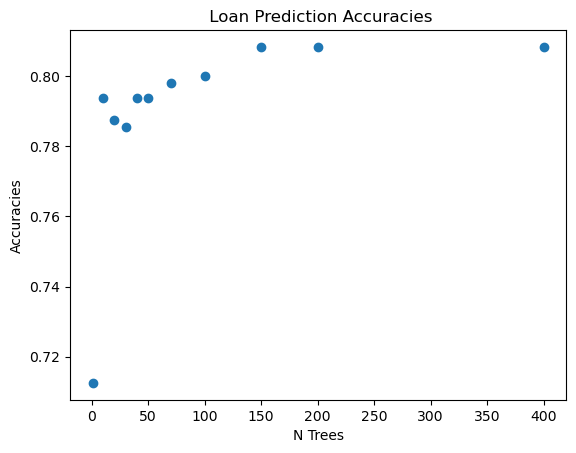

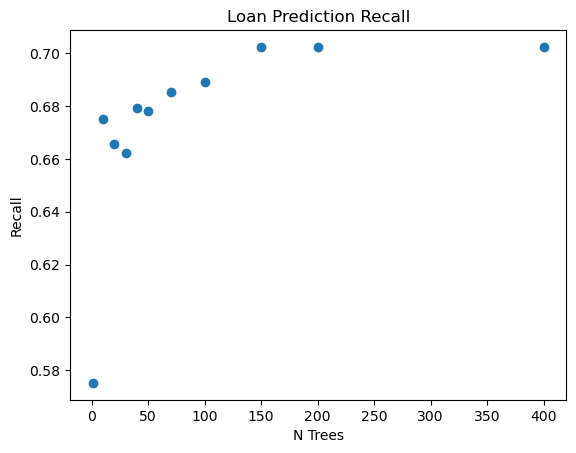

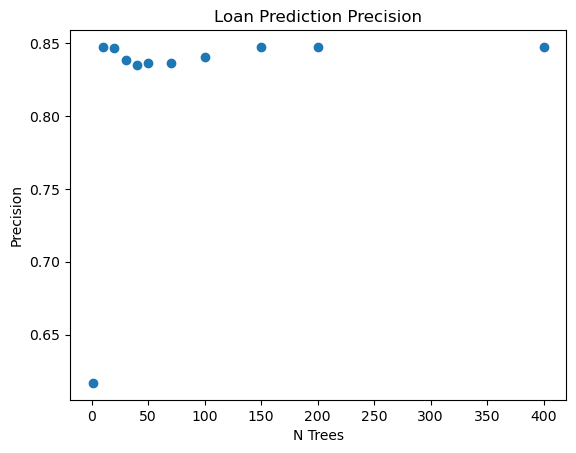

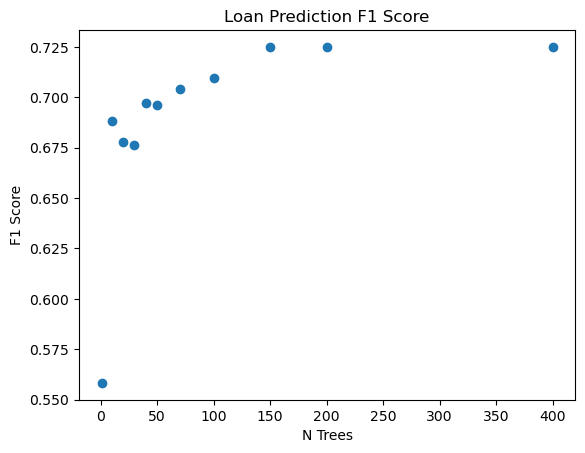

Loan Prediction Accuracies
{1: 0.7125, 10: 0.79375, 20: 0.7875, 30: 0.7854166666666667, 40: 0.79375, 50: 0.79375, 70: 0.7979166666666667, 100: 0.8, 150: 0.8083333333333333, 200: 0.8083333333333333, 400: 0.8083333333333333}
Loan Prediction Recall
{1: 0.5751315351315351, 10: 0.6752680652680653, 20: 0.6655011655011654, 30: 0.6624475524475524, 40: 0.6791375291375291, 50: 0.6781118881118882, 70: 0.6852913752913753, 100: 0.6891375291375291, 150: 0.7024708624708624, 200: 0.7024708624708624, 400: 0.7024708624708624}
Loan Prediction Precision
{1: 0.6168491166456282, 10: 0.8473511223711453, 20: 0.8462943189622185, 30: 0.8386148878056362, 40: 0.8347814502728003, 50: 0.8366623474519331, 70: 0.8364392035612966, 100: 0.8406759151850131, 150: 0.8470612702345768, 200: 0.8470612702345768, 400: 0.8470612702345768}
Loan Prediction F1 Score
{1: 0.5583135456019692, 10: 0.6884552234925857, 20: 0.6780768633648289, 30: 0.6763721073368961, 40: 0.6972560121379281, 50: 0.6962163171207676, 70: 0.7041537759719635,

In [26]:
run_loan()